In [83]:
from __future__ import print_function
import cv2 as cv
import argparse
import numpy as np
import math
from PIL import Image
import os
import sklearn.cluster
from joblib import dump, load
import torch
import clip

In [84]:
model = load('model.joblib')

device = "cuda" if torch.cuda.is_available() else "cpu"
model2, preprocess = clip.load('ViT-B/32', device)

CLP = True

100%|███████████████████████████████████████| 338M/338M [00:26<00:00, 13.4MiB/s]


In [85]:
# 4
def ImgToVec(img):
    gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    kp = sift.detect(gray,None)
    arr = [d.pt for d in kp]
    prediction = model.predict(arr)
    hist, bin_edges = np.histogram(prediction, bins=1024)
    return hist

def ImgToVecCLIP(image):
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        t = model2.encode_image(image_input)[0].numpy()
        t = (t - t.min()) / (t.max() - t.min())
        return t

In [90]:
#5
import pandas as pd

path = 'c:/Users/stalk/GitReps/Laboratory-13.-Search-for-similar-images/VOC2012/JPEGImages'

def IndexThisShit(path, clp, out):
    ind = 0
    df = pd.DataFrame(columns=['ind','path','vect'])
    for filename in os.listdir(path):
        pt = path+'/'+filename
        img = cv.imread(pt)
        if clp:
            img = Image.open(pt)
            #img.Load()
            res = ImgToVecCLIP(img)
        else:
            res = ImgToVec(img)
        rs = " ".join(map(str,res))
        
        new_row = [ind, pt, rs]
        #df = df.append(new_row, ignore_index=True)
        df.loc[ len(df.index )] = new_row
        ind+=1
        if ind > 5000:
            break
    #return Arr
    df.to_csv(out)


In [91]:
#5
out = ''
if CLP:
    out ='c:/Users/stalk/GitReps/Laboratory-13.-Search-for-similar-images/5DS_CLIP.csv'
else:
    out = 'c:/Users/stalk/GitReps/Laboratory-13.-Search-for-similar-images/5DS.csv'


IndexThisShit(path, CLP, out)

In [92]:
#5
def decode(str):
    str = str.split(' ')
    #str =map(float, str)
    str = np.asarray(list(map(float, str)))
    #str = str / np.sum(str)
    return list(str)

def get_from_csv(csv_path):
    dataframe = pd.read_csv(csv_path)
    dataframe['vect'] = dataframe['vect'].map(decode)
    return dataframe

df = get_from_csv(out)


In [93]:
df

Unnamed: 0   ind                                               path  \
0              0     0  c:/Users/stalk/GitReps/Laboratory-13.-Search-f...   
1              1     1  c:/Users/stalk/GitReps/Laboratory-13.-Search-f...   
2              2     2  c:/Users/stalk/GitReps/Laboratory-13.-Search-f...   
3              3     3  c:/Users/stalk/GitReps/Laboratory-13.-Search-f...   
4              4     4  c:/Users/stalk/GitReps/Laboratory-13.-Search-f...   
...          ...   ...                                                ...   
4996        4996  4996  c:/Users/stalk/GitReps/Laboratory-13.-Search-f...   
4997        4997  4997  c:/Users/stalk/GitReps/Laboratory-13.-Search-f...   
4998        4998  4998  c:/Users/stalk/GitReps/Laboratory-13.-Search-f...   
4999        4999  4999  c:/Users/stalk/GitReps/Laboratory-13.-Search-f...   
5000        5000  5000  c:/Users/stalk/GitReps/Laboratory-13.-Search-f...   

                                                   vect  
0     [0.74983865, 0.8638315, 0.8168315, 0.8562305, ...  
1     [0.7035105, 0.7224271, 0.7180191, 0.78596765, ...  
2     [0.7382976, 0.755043, 0.68976444, 0.78216195, ...  
3     [0.81663424, 0.91074437, 0.86777216, 0.8660261...  
4     [0.8350896, 0.8369031, 0.7591516, 0.863626, 0....  
...                                                 ...  
4996  [0.72911596, 0.7945551, 0.7562255, 0.773976, 0...  
4997  [0.81613827, 0.76803267, 0.78098786, 0.8054277...  
4998  [0.76851356, 0.87396884, 0.79793763, 0.8343649...  
4999  [0.749204, 0.75383896, 0.74091154, 0.7186591, ...  
5000  [0.78387856, 0.83123094, 0.7561693, 0.8646004,...  

[5001 rows x 4 columns]

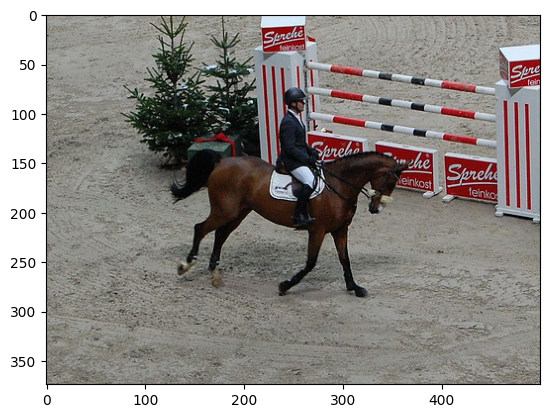

In [94]:
#6
import scipy
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors

def load_rbg(path):
    return cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB)

path = 'c:/Users/stalk/GitReps/Laboratory-13.-Search-for-similar-images/VOC2012/JPEGImages/2011_007199.jpg'
#img = cv.imread(path)#coder_kmeans.encode(path)
img = load_rbg(path)
plt.imshow(load_rbg(path))

In [96]:
neighbors_kmeans = NearestNeighbors(n_neighbors=5, metric='cosine', n_jobs=-1)
neighbors_kmeans.fit(np.vstack(df['vect'].values), df.index.values)
if CLP:
    img = Image.open(path)
    img = ImgToVecCLIP(img)
else:
    img = ImgToVec(img)
#img = img / np.sum(img)
_, indices_kmeans = neighbors_kmeans.kneighbors([img], n_neighbors=10)
indices_kmeans

array([[2422,  100, 1975, 4820,  320, 4218,   54,  618,   61, 2906]],
      dtype=int64)

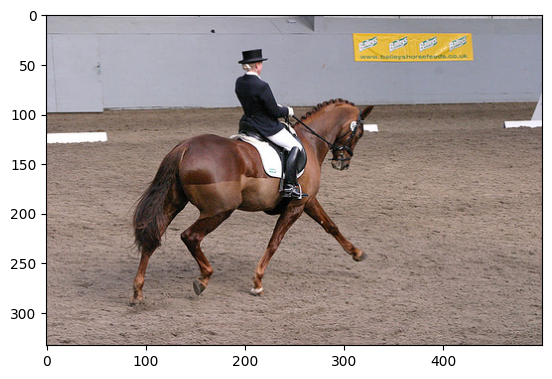

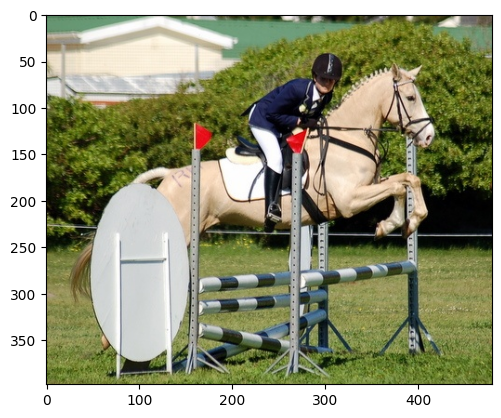

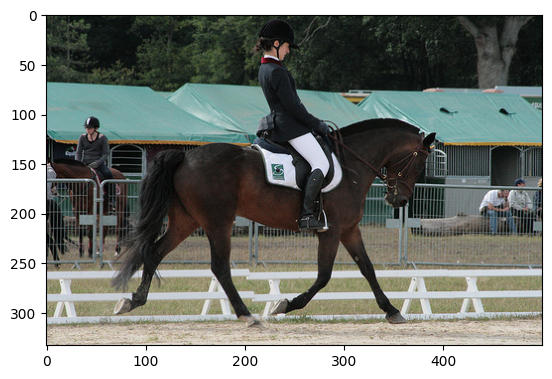

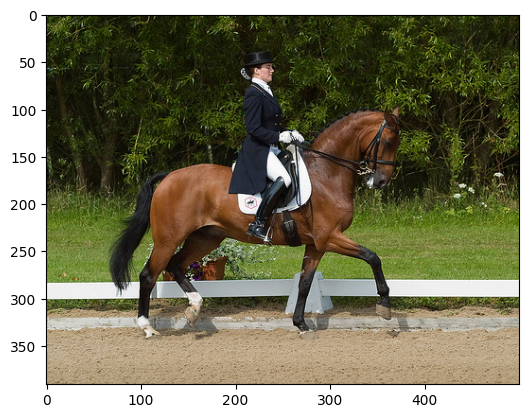

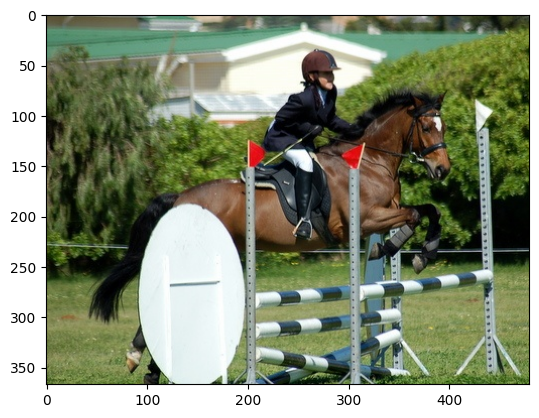

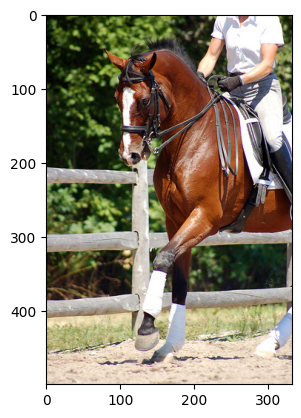

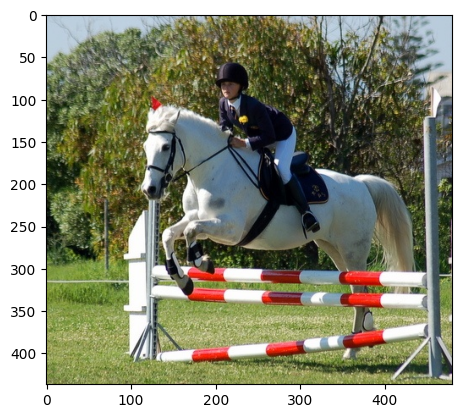

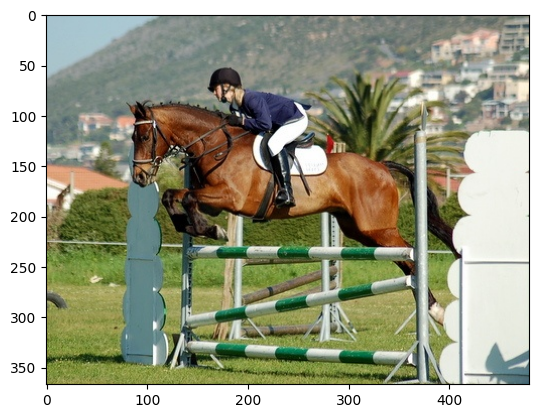

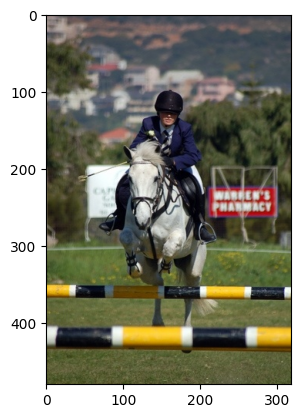

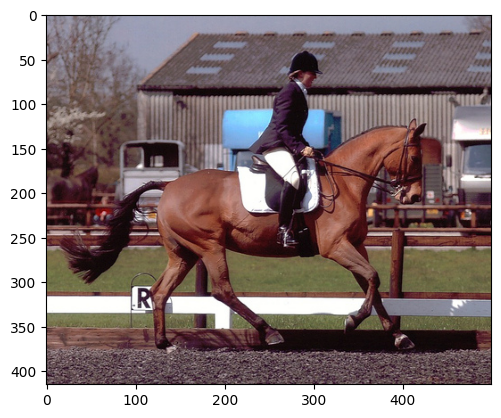

In [97]:
for idx in indices_kmeans.flat:
    plt.imshow(load_rbg(df.loc[idx]['path']))
    plt.show()